In [1]:
import time
import threading

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg

import pandas as pd
import pandas_datareader.data as web

In [2]:
from sklearn import linear_model
import pandas as pd

In [3]:
d=2
M=150

def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

def vectorfieldSABR(state,increment):
    return np.array([(np.sqrt(state[0]**2))**0.7*np.exp(-0.5*state[1]),0.1])*increment[0]+np.array([0,0.25*(state[0]+state[1])])*increment[1]

def vectorfield2d(state,increment):
    return np.array([(2.0*np.sqrt(state[1]**2))**0.7+np.sin(state[1]),1.0*state[1]+np.cos(state[1])])*increment[0]+np.array([(2.0*np.sqrt(state[1]**2))**0.7,0.0*state[1]])*increment[1]

def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        B = 0.0*nilpotent(M) + np.random.normal(0.0,0.03,size=(M,M))
        B = np.random.permutation(B)
        A = A + [B]
        beta = beta + [0.0*canonical(i,M)+np.random.normal(0.0,0.03,size=(M,1))]
    return [A,beta]

In [4]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

In [5]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,dimensionR,vectorfield,timesteps):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
        self.dimensionR = dimensionR
        self.vectorfield = vectorfield
        self.timesteps = timesteps

    def path(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]
        for i in range(self.timesteps):
            helper = np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def anypath(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]#[np.ones((self.dimension,1))*self.initialvalue]

        for i in range(self.timesteps):
            helper = np.cos(BMpath[-1]*50)*self.timehorizon/self.timesteps#np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def reservoir(self,BMpath,scaling,k):
        reservoirpath = [canonical(k,self.dimensionR)*self.initialvalue]
        for i in range(self.timesteps):
            increment = scaling*(BMpath[i+1]-BMpath[i])
            reservoirpath = reservoirpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(reservoirpath[-1]+reservoirfield(reservoirpath[-1],increment))]
        return reservoirpath

In [6]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

#### Generate stock prices

In [7]:
# Number of seconds/hours in one trading day: 9.30-16.30
sec = 150 #25200
min = 420

In [8]:
SDE_of_interest = SDE(7,1.0,2,d,M,vectorfield2d,sec)
#SDE_of_interest = SDE(7,1.0,2,d,M,vectorfieldSABR,10000)
training = SDE_of_interest.path()

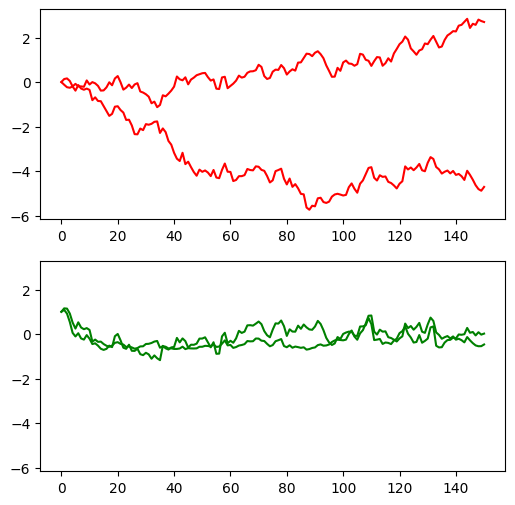

In [9]:
f1,p1=plt.subplots(2,1,figsize=(6,6),sharey=True)
p1[0].plot(training[0],'r')
p1[1].plot(training[1],'g')
#plt.savefig('trainingpath.pdf')
plt.show()

In [10]:
available_SDE_data_list = []
available_BM_data_list = []

available_BM_data = training[0][0]
available_SDE_data = training[1][0]

In [11]:
print(len(training[0]))

151


In [12]:
def read_data_line_by_line(data_SDE, data_BM):
    global available_BM_data
    global available_SDE_data
    
    for i in range(1, len(training[0])+1): # len of list
        print(np.shape(available_BM_data))
        print(np.shape(available_SDE_data))

        available_BM_data_list.append(data_BM[i])
        available_SDE_data_list.append(data_SDE[i])

        available_BM_data = np.array(available_BM_data_list)
        available_SDE_data = np.array(available_SDE_data_list)

        time.sleep(1) 

In [ ]:
def train_model():
    global available_BM_data
    global available_SDE_data

    while True:
        if (len(available_SDE_data) % 10) == 0: 

            print("shape available BM data", np.shape(available_BM_data))
            print("shape available SDE data", np.shape(available_SDE_data))

            # Error happens here that's why we don't continue
            # I need to modify the class SDE so that reservoir does not have to range up to timesteps (not possible 
            # since I make my timestep "move".)

            X = SDE_of_interest.reservoir(available_BM_data,1,0) 
            Xtrain = np.squeeze(X) 

            print("shape of Xtrain", np.shape(Xtrain))

            Ytrain = np.squeeze(available_SDE_data) 

            print("shape of Ytrain", np.shape(Ytrain)) 

            lm = linear_model.Ridge(alpha=0.05)
            model = lm.fit(Xtrain, Ytrain)
            plt.plot(model.predict(Xtrain),'r')
            plt.plot(Ytrain,'b')
            plt.show()
            model.score(Xtrain,Ytrain)
            model.coef_

            print("Model trained successfully")

        if len(available_SDE_data) == 151:
            break

In [ ]:
# Start the data reading thread
data_thread = threading.Thread(target=read_data_line_by_line, args=(training[1], training[0]))
data_thread.start()

# Start the model training thread
train_thread = threading.Thread(target=train_model)
train_thread.start()

# Join threads to ensure they complete (in a real scenario, you may not need to join if you want continuous execution)
data_thread.join()
train_thread.join()


In [ ]:
available_BM_data_list = []
available_SDE_data_list = []

for i in range(SDE_test_data.shape[0]):

    new_line_BM = BM_test_data[i] 
    new_line_SDE = SDE_test_data[i]   

    available_BM_data_list.append(new_line_BM)
    available_SDE_data_list.append(new_line_SDE)

    available_BM_data = np.array(available_BM_data_list)
    available_SDE_data = np.array(available_SDE_data_list)
    
    # Train the model every 3 minutes
    if i % 180 == 0:
        # Here I should also calculate the underlying BM of the SDE, we assume for now that it is available
        X=SDE_of_interest.reservoir(available_BM_data,1,0) 
        Xtrain = np.squeeze(X) 

        Ytrain = np.squeeze(available_SDE_data)  

        lm = linear_model.Ridge(alpha=0.05)#
        model = lm.fit(Xtrain,Ytrain)
        plt.plot(model.predict(Xtrain),'r')
        plt.plot(Ytrain,'b')
        plt.show()
        model.score(Xtrain,Ytrain)
        model.coef_

        ##############
        # Problems:
        ##############
        """
        This programm does not have an input every second, if I hit 180 seconds, then I train the model, which takes multiple 
        seconds. I need to have a times input running continuously.

        I need the model to predict once it's trained, and of course predict more time steps than it needs to train
        otherwise it is useless. I don't want to train it from beginning but I want more to continue training it.

        Once I have the real data, I want to evaluate the model on the real data and eventualy change some parameters
        """
        
    
    if sec_or_min == "sec":
        time.sleep(1)
    else:
        time.sleep(60)

# Final available data as a numpy array
available_data = np.array(available_data_list)
print("Final available data:")
print(available_data)
